In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-08-16  HDFCBANK.NS  1584.562012  1606.199951  1609.650024   
1         2023-08-16      INFY.NS  1380.753418  1418.500000  1419.949951   
2         2023-08-16  RELIANCE.NS  2566.085449  2575.149902  2582.800049   
3         2023-08-16       TCS.NS  3408.769287  3458.399902  3466.000000   
4         2023-08-17  HDFCBANK.NS  1575.782104  1597.300049  1609.900024   

Attribute          Low         Open      Volume  
0          1581.300049  1583.099976  17068771.0  
1          1405.400024  1410.800049   7735313.0  
2          2551.000000  2551.000000   5101556.0  
3          3435.199951  3450.000000   1328445.0  
4          1594.000000  1597.599976  26442020.0  


Now, let’s have a look at the stock market performance of these companies in the stock market over time:

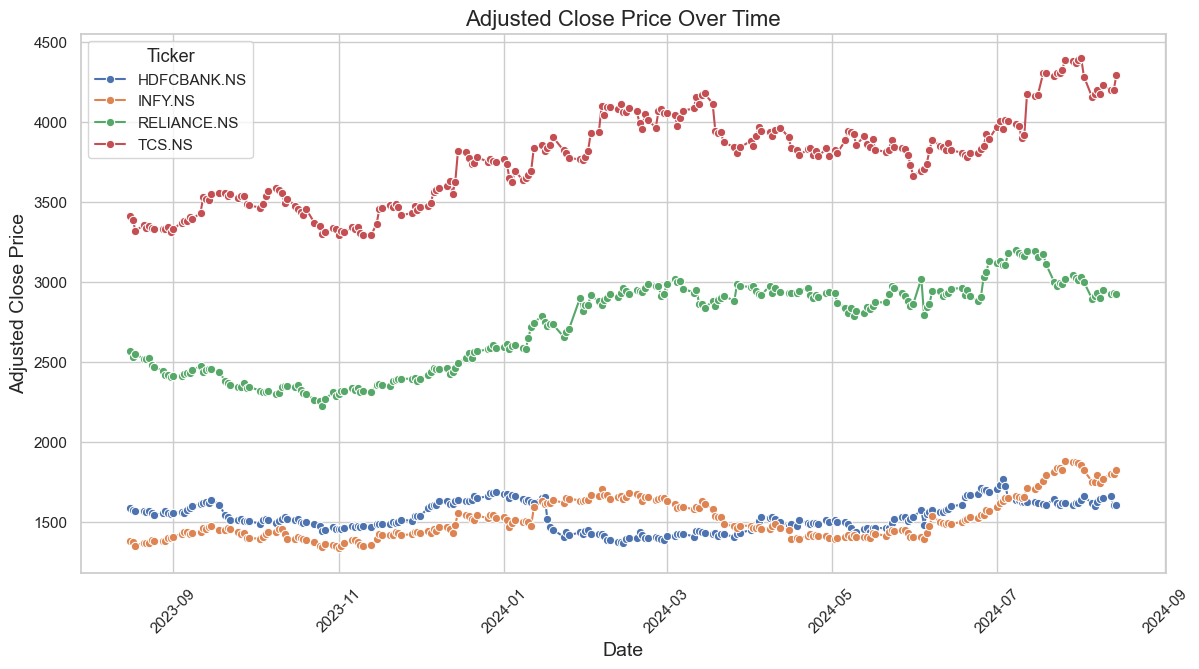

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

The graph displays the adjusted close prices of four stocks (HDFCBANK.NS, INFY.NS, RELIANCE.NS, TCS.NS) over time from September 2023 to September 2024. It highlights that TCS has the highest adjusted close prices, followed by RELIANCE, INFY (Infosys), and HDFCBANK. The prices for RELIANCE and TCS show noticeable upward trends, which indicates strong performance, while HDFCBANK and INFY exhibit more stability with relatively lower price fluctuations.

Now, let’s compute the 50-day and 200-day moving averages and plot these along with the Adjusted Close price for each stock:

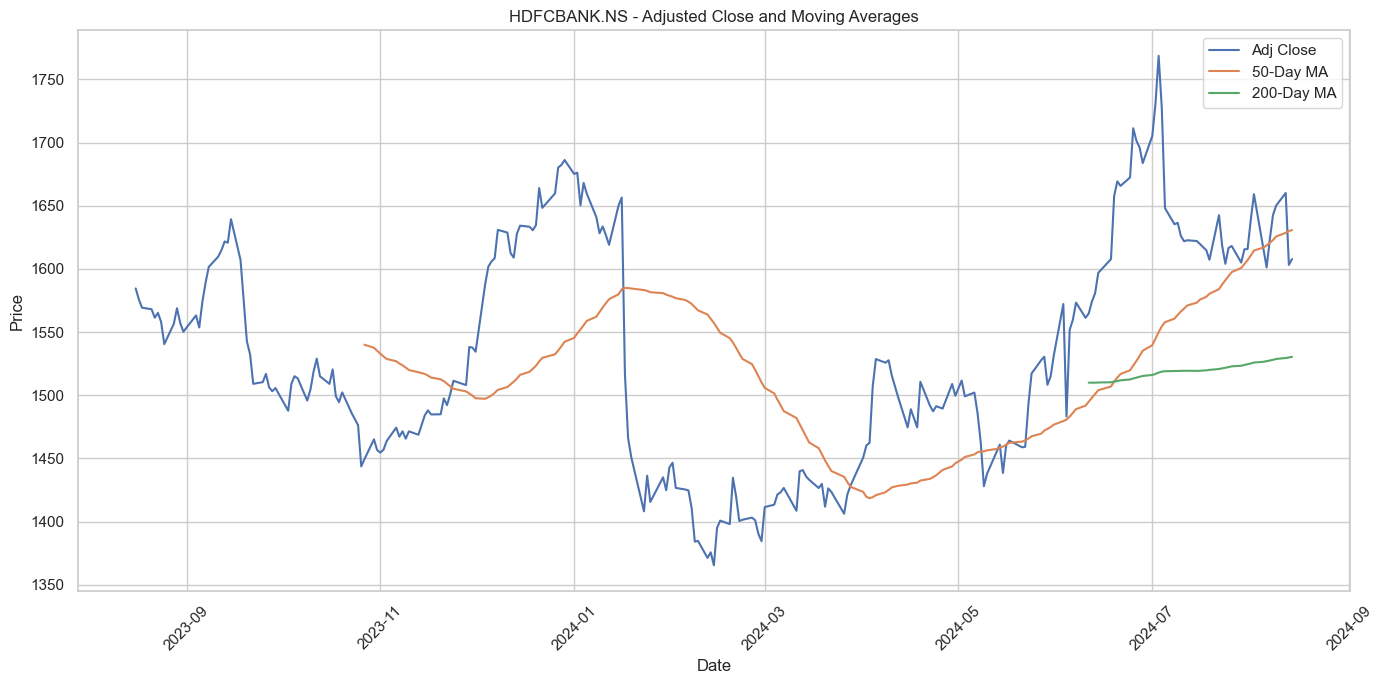

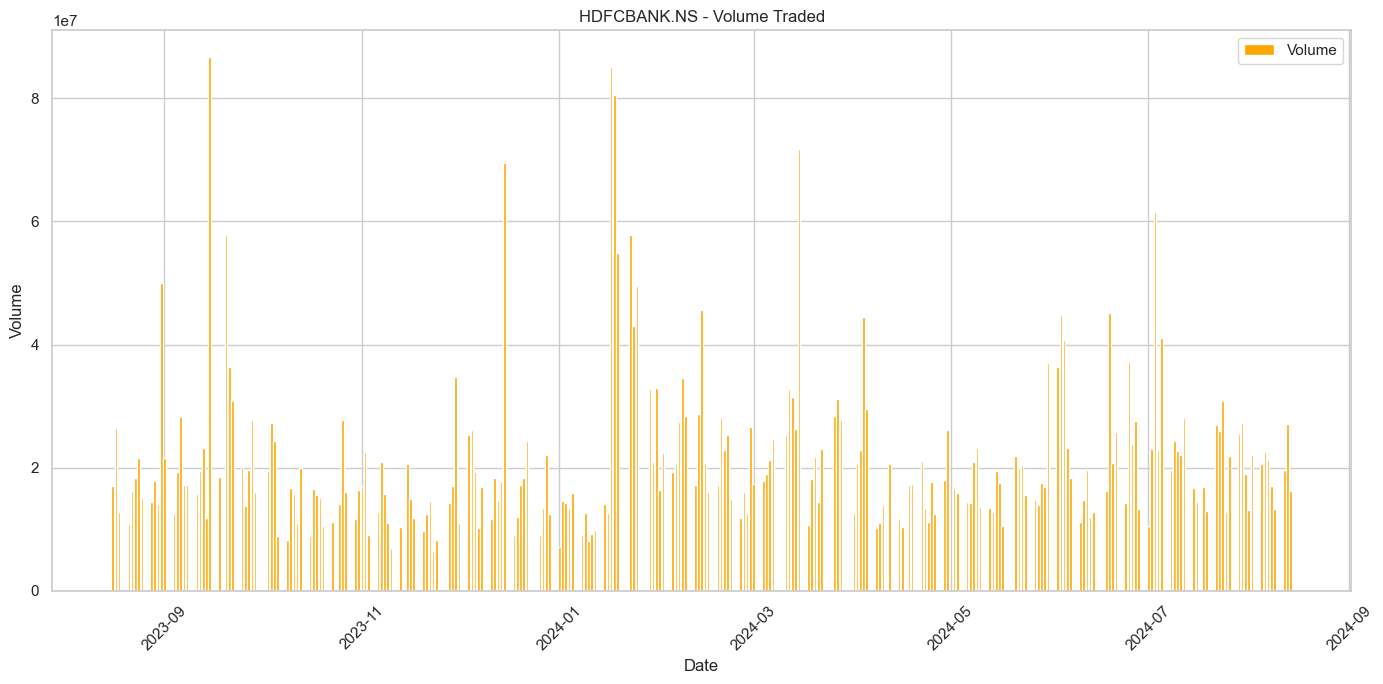

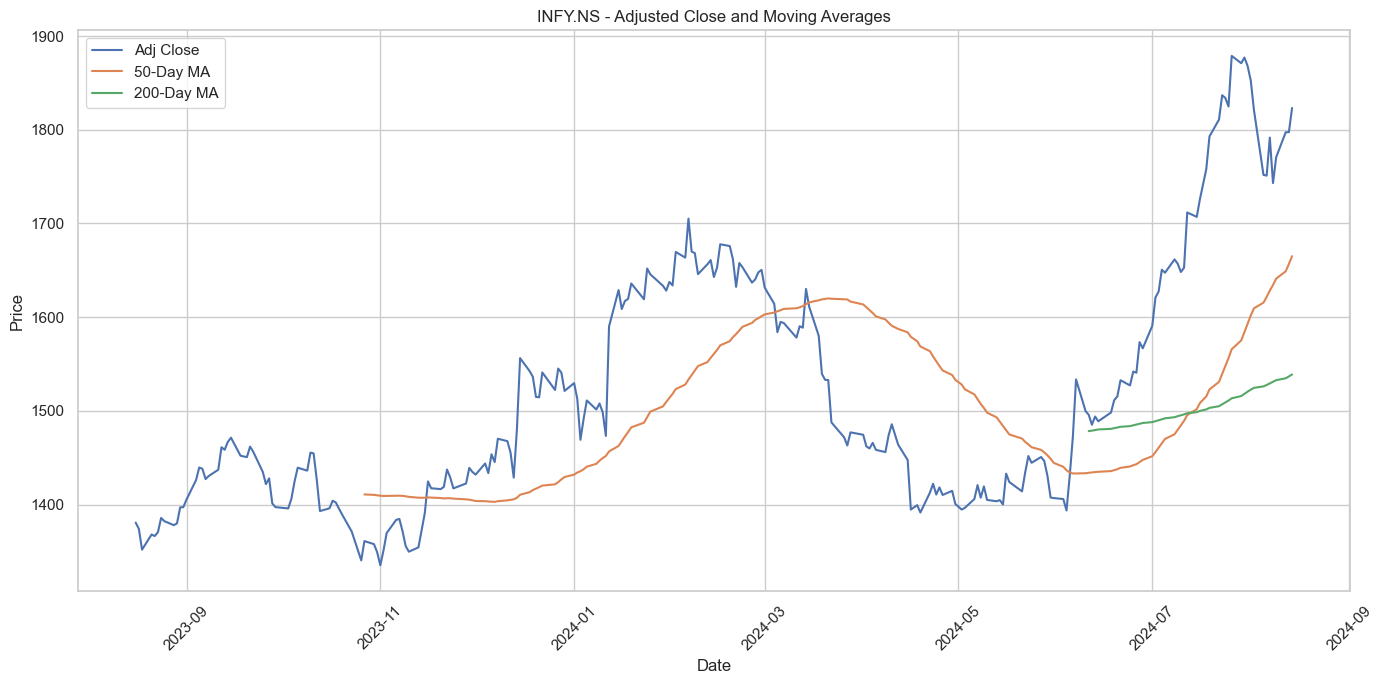

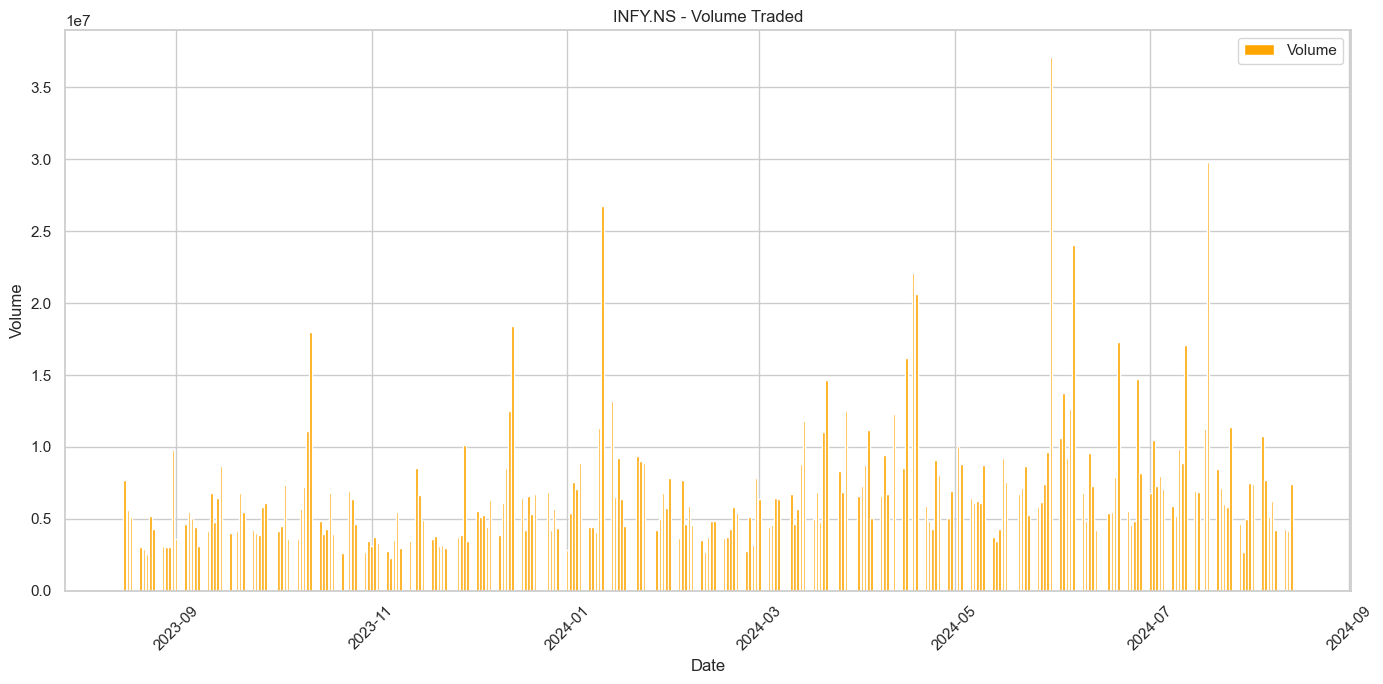

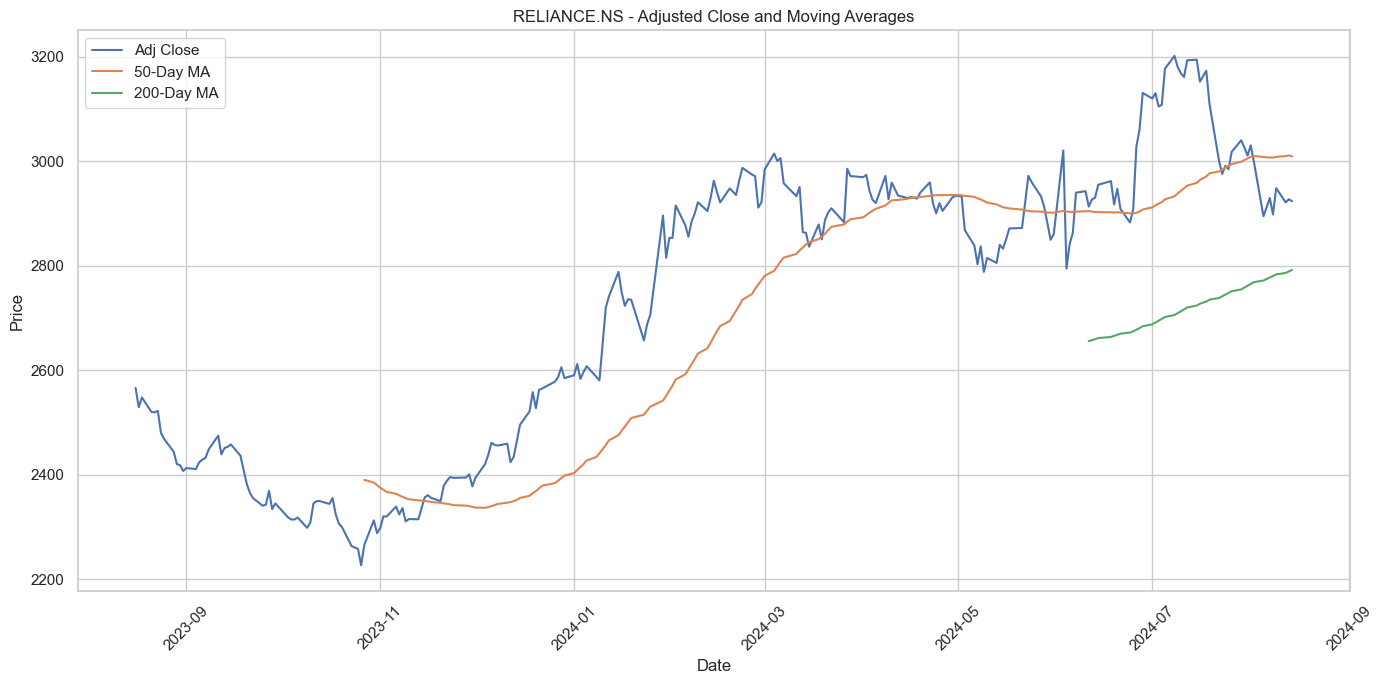

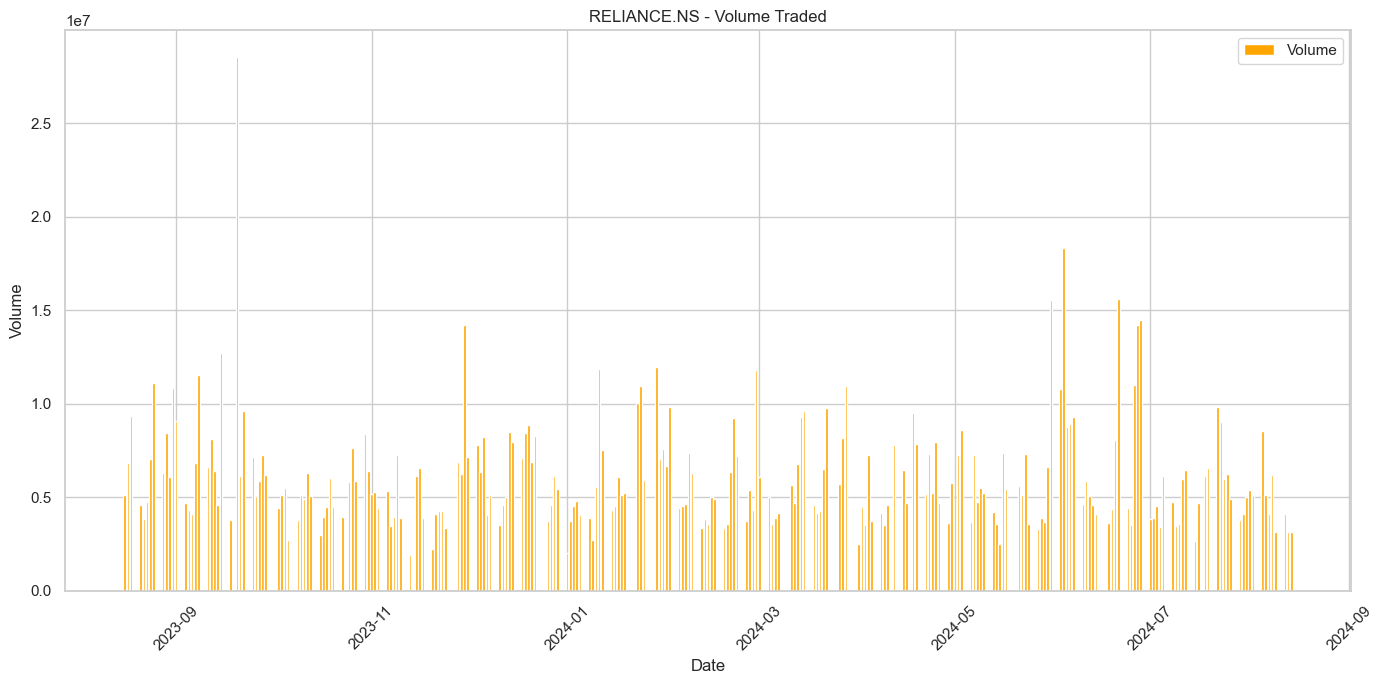

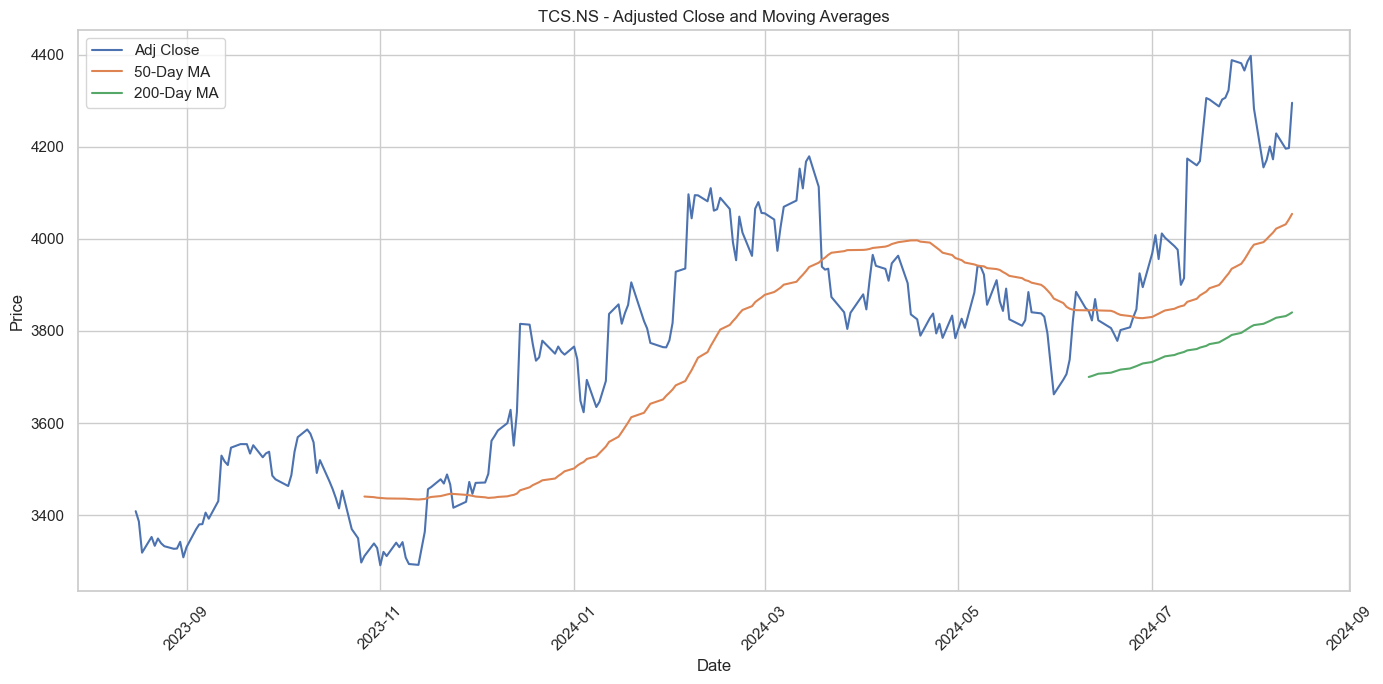

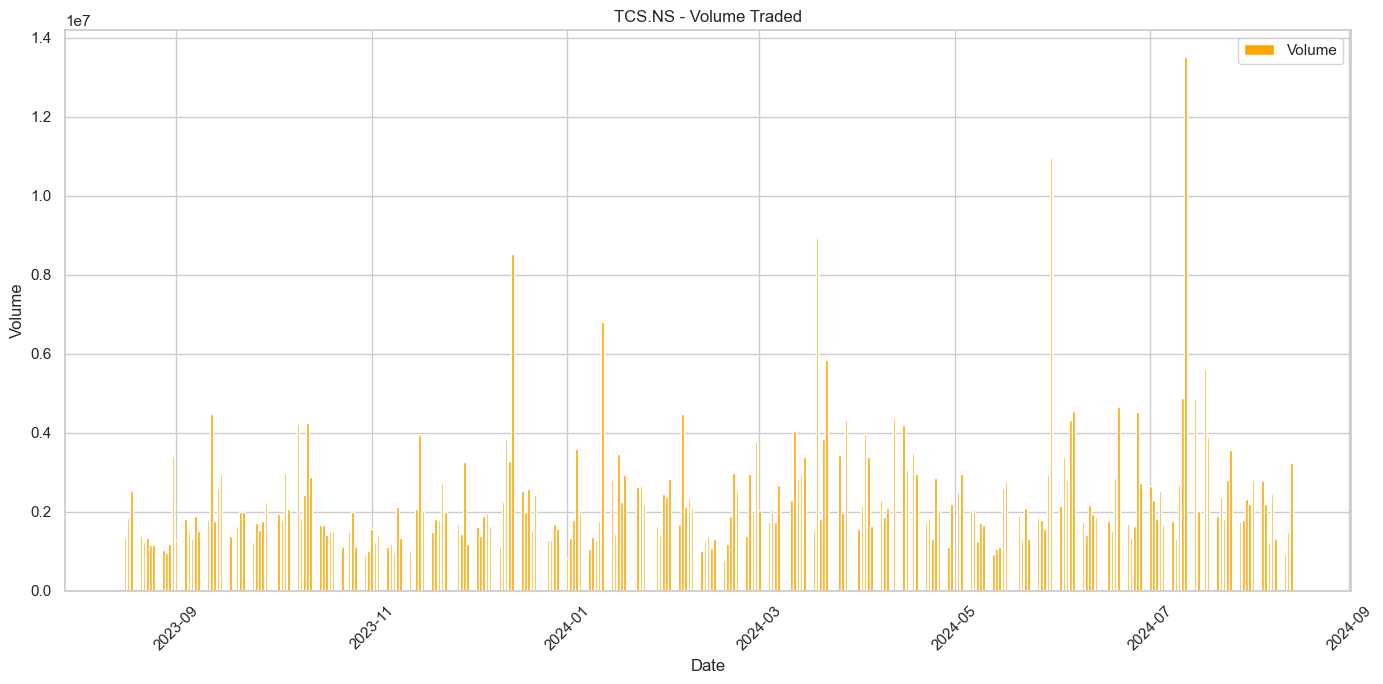

In [11]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

For HDFCBANK and INFY, the prices initially decline but later show signs of recovery, as indicated by the moving averages. RELIANCE and TCS display a more consistent upward trend in their adjusted close prices. The volume traded graphs highlight significant trading activity at various points, with spikes indicating high trading volumes, particularly noticeable in HDFCBANK and RELIANCE around early 2024. These insights are crucial for understanding price movements and trading behaviours, which assist in making informed investment decisions.

Now, let’s have a look at the distribution of daily returns of these stocks:

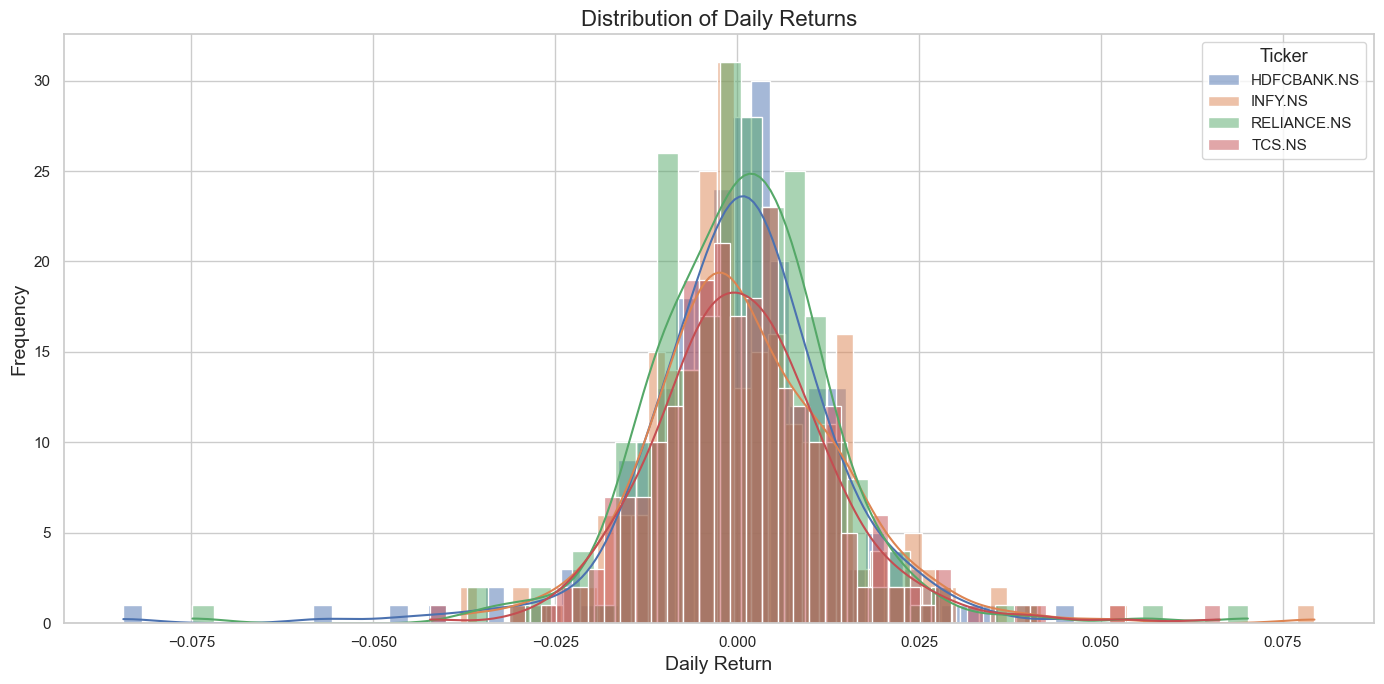

In [14]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

The distributions are approximately normal, centred around zero, which indicates that most daily returns are close to the average return. However, there are tails on both sides, which reflect occasional significant gains or losses. INFY and RELIANCE appear to have slightly wider distributions, which suggests higher volatility compared to HDFCBANK and TCS.

Now, let’s see if there’s any correlation between all these stocks:

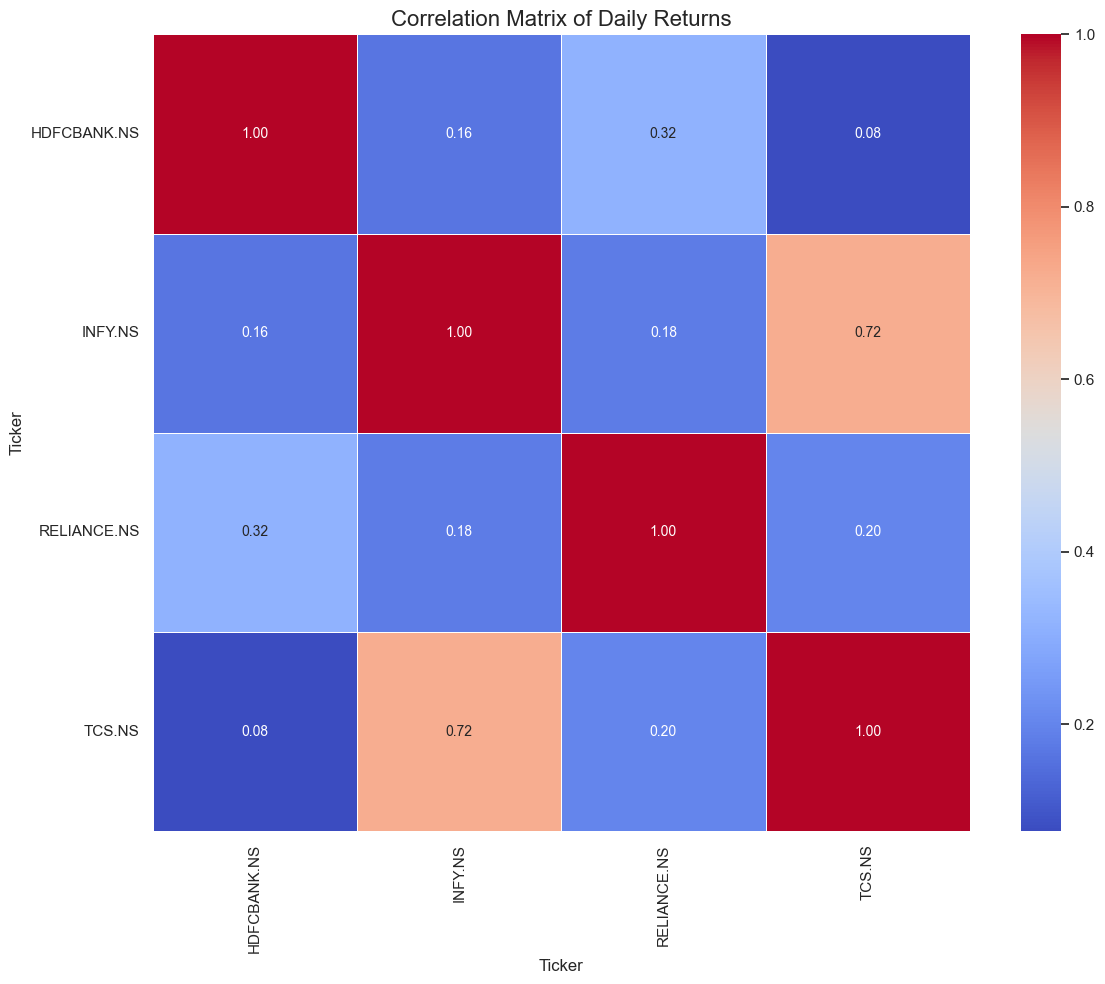

In [17]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

 These varying correlations suggest potential diversification benefits; combining stocks with lower correlations can reduce overall portfolio risk.

Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:

1. Calculate the expected returns and volatility for each stock.
2. Generate a series of random portfolios to identify the efficient frontier.
3. Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

Let’s calculate the expected returns and volatility for each stock:

In [22]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.038814,0.216905
INFY.NS,0.312396,0.220331
RELIANCE.NS,0.158003,0.213430
TCS.NS,0.260708,0.205565


INFY has the highest expected return (31.23%) and moderate volatility (22.03%), which indicates a potentially high-reward investment with relatively higher risk. RELIANCE and TCS also have high expected returns (15.81% and 26.07% respectively) with moderate volatility (21.34% and 20.55%). HDFCBANK has the lowest expected return (0.03%) and moderate volatility (21.69%), which makes it the least attractive in terms of risk-adjusted returns.

Next, we will:

1. Generate a large number of random portfolio weights.
2. Calculate the expected return and volatility for each portfolio.
3. Plot these portfolios to visualize the efficient frontier.


Let’s generate the random portfolios and plot the efficient frontier:

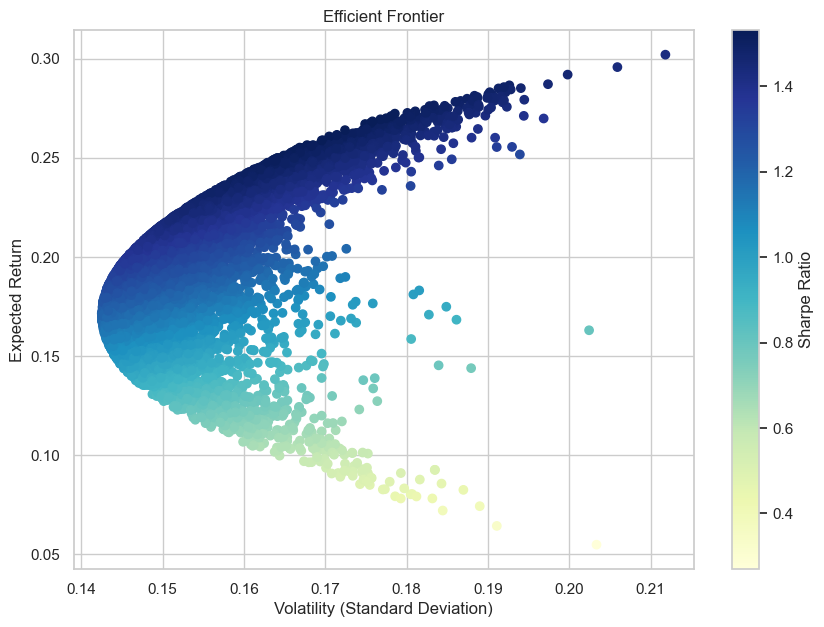

In [25]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.



Here’s how to identify the portfolio with the maximum Sharpe ratio:

In [29]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.26397054950951676, 0.17243167884253022, 1.5308703788158473)

The portfolio with the maximum Sharpe ratio has the following characteristics:

Expected Return: ~26.39%
Volatility: ~17.24%
Sharpe Ratio: ~1.53
Next, let’s identify the weights of the stocks in the portfolio that yield the maximum Sharpe ratio:

In [32]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.339295
1,INFY.NS,0.265342
2,RELIANCE.NS,0.011174
3,TCS.NS,0.384189


The output shows a diversified portfolio with the following allocations:

HDFCBANK (33.92%)
INFY (26.53%)
RELIANCE (11.17%)
and TCS (38.42%).
TCS has the highest allocation, which indicates its significant contribution to the portfolio’s performance, while RELIANCE has the smallest allocation. This balanced allocation aims to maximize returns while minimizing risk by leveraging individual stock performances and their correlations.